Preparing data for learning - Issue #2 is resolved by this.

In [1]:
### Resetting all variables

%reset -f

In [3]:
### Importing packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append('../python')
from earfcn_to_freq import earfcn_to_freq
from haversine import haversine
from calc_bearing import calc_bearing
from gain_calc import gain_calc

In [4]:
### Data Preprocesing

df = pd.read_csv('../data/qualipoc_data/cbrs_radio_2024_oct_nov.csv', sep=";")
df.rename(columns={'PCI/PSC/BSIC': 'PCI'}, inplace=True)
df['Frequency'] = df['DL EARFCN'].apply(earfcn_to_freq)
df = df[df['DL Bandwidth'] == 20]
df.drop(columns=['Date', 'Time', 'Device Name', 'Carrier Index', 'Technology Band', 'Band Number', 'DL EARFCN', 'SCC Index', 'TxAntennas',\
                 'Frequency Number', 'DL Subcarrier Spacing', 'DL Carriers Radio', 'Cell Id', 'eNB-Id', 'Sector Id', 'Operator', 'DL Bandwidth'], inplace=True)

pci_map = {
    0: { 'BS': 1, 'Latitude': 41.65425, 'Longitude': -86.242694, 'Azimuth': 60, 'Downtilt': 4, 'Height': 21, 'Frequency': 3670 },
    3: { 'BS': 1, 'Latitude': 41.65425, 'Longitude': -86.242694, 'Azimuth': 120, 'Downtilt': 4, 'Height': 21, 'Frequency': 3640 },
    6: { 'BS': 1, 'Latitude': 41.65425, 'Longitude': -86.24375, 'Azimuth': 180, 'Downtilt': 4, 'Height': 21, 'Frequency': 3580 },
    9: { 'BS': 1, 'Latitude': 41.65425, 'Longitude': -86.24375, 'Azimuth': 240, 'Downtilt': 4, 'Height': 21, 'Frequency': 3690 },
    12: { 'BS': 1, 'Latitude': 41.654639, 'Longitude': -86.24375, 'Azimuth': 300, 'Downtilt': 4, 'Height': 29, 'Frequency': 3560 },
    15: { 'BS': 1, 'Latitude': 41.654639, 'Longitude': -86.24375, 'Azimuth': 0, 'Downtilt': 4, 'Height': 29, 'Frequency': 3580 },
    18: { 'BS': 4, 'Latitude': 41.668678, 'Longitude': -86.312222, 'Azimuth': 70, 'Downtilt': -1, 'Height': 12, 'Frequency': 3690 },
    21: { 'BS': 4, 'Latitude': 41.668678, 'Longitude': -86.312222, 'Azimuth': 130, 'Downtilt': -1, 'Height': 12, 'Frequency': 3640 },
    24: { 'BS': 2, 'Latitude': 41.663278, 'Longitude': -86.254139, 'Azimuth': 60, 'Downtilt': 4, 'Height': 44, 'Frequency': 3670 },
    27: { 'BS': 2, 'Latitude': 41.663278, 'Longitude': -86.254139, 'Azimuth': 120, 'Downtilt': 4, 'Height': 44, 'Frequency': 3640 },
    30: { 'BS': 2, 'Latitude': 41.663278, 'Longitude': -86.254139, 'Azimuth': 180, 'Downtilt': 4, 'Height': 44, 'Frequency': 3580 },
    33: { 'BS': 2, 'Latitude': 41.663278, 'Longitude': -86.254139, 'Azimuth': 240, 'Downtilt': 4, 'Height': 44, 'Frequency': 3690 },
    36: { 'BS': 2, 'Latitude': 41.663278, 'Longitude': -86.254139, 'Azimuth': 300, 'Downtilt': 4, 'Height': 44, 'Frequency': 3560 },
    39: { 'BS': 2, 'Latitude': 41.663278, 'Longitude': -86.254139, 'Azimuth': 0, 'Downtilt': 4, 'Height': 44, 'Frequency': 3580 },
    42: { 'BS': 3, 'Latitude': 41.67225, 'Longitude': -86.292778, 'Azimuth': 120, 'Downtilt': 4, 'Height': 33, 'Frequency': 3670 },
    45: { 'BS': 3, 'Latitude': 41.67225, 'Longitude': -86.292778, 'Azimuth': 180, 'Downtilt': 4, 'Height': 33, 'Frequency': 3640 },
    48: { 'BS': 3, 'Latitude': 41.67225, 'Longitude': -86.292778, 'Azimuth': 240, 'Downtilt': 4, 'Height': 33, 'Frequency': 3690 },
    51: { 'BS': 3, 'Latitude': 41.67225, 'Longitude': -86.292778, 'Azimuth': 300, 'Downtilt': 4, 'Height': 33, 'Frequency': 3580 },
}
df_pci_map = pd.DataFrame.from_dict(pci_map, orient='index').reset_index()
df_pci_map.rename(columns={'index': 'PCI'}, inplace=True)
del pci_map

df = df.merge(df_pci_map[['PCI', 'BS', 'Latitude', 'Longitude', 'Azimuth', 'Downtilt', 'Height']], on='PCI', how='left')
df.rename(columns={'Latitude_x': 'ue_Latitude', 'Latitude_y': 'bs_Latitude', 'Longitude_x': 'ue_Longitude', 'Longitude_y': 'bs_Longitude',\
                   'Azimuth': 'bs_Azimuth', 'Downtilt': 'bs_Downtilt', 'Height': 'bs_Height'}, inplace=True)
del df_pci_map

df_antenna = pd.read_csv('../data/antenna.csv')

df[['Distance_2d', 'Distance_3d']] = df.apply(lambda row: haversine(row['ue_Latitude'], row['ue_Longitude'],
                                                                    row['bs_Latitude'], row['bs_Longitude'], row['bs_Height']), axis=1, result_type='expand')
df['Distance_3d_log'] = 10 * np.log10(df['Distance_3d'])
df['Distance_3d_log'] = 10 * np.log10(df['Distance_3d'])
df['ue_Elevation'] = 90 - np.rad2deg(np.arctan(df['bs_Height'] / df['Distance_2d']))

df['ue_Azimuth'] = df.apply(lambda row: calc_bearing(row['bs_Latitude'], row['bs_Longitude'], row['ue_Latitude'], row['ue_Longitude'], row['bs_Azimuth']), axis=1)

df[['gain_Azimuth', 'gain_Elevation']] = 20.5 * df.apply(lambda row: pd.Series(gain_calc(df_antenna, row['ue_Azimuth'], row['ue_Elevation'])), axis=1)
# It is not 20Mhz/15khz as there are 100 PRBs in 20Mhz conf (rest are guard bands)
df['bs_Power'] = 29.5 + (df['gain_Azimuth']*df['gain_Elevation']/20.5) - 10*np.log10(1200)

del df_antenna

In [5]:
X_interpret = df[['BS', 'PCI', 'bs_Power', 'Distance_3d', 'RSRP', 'RSRQ', 'SINR', 'RSSI (LTE)']]
print(X_interpret.groupby(['BS', 'PCI']).size().reset_index(name='counts'))

    BS  PCI  counts
0    2   24     193
1    2   27      71
2    2   30     251
3    2   33    3685
4    2   36    3991
5    2   39     503
6    3   42   16098
7    3   45    3362
8    3   48    6660
9    3   51    5606
10   4   18    5151
11   4   21    1669


C:\Users\jpalathi\AppData\Local\Temp\ipykernel_22336\844557900.py:10: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


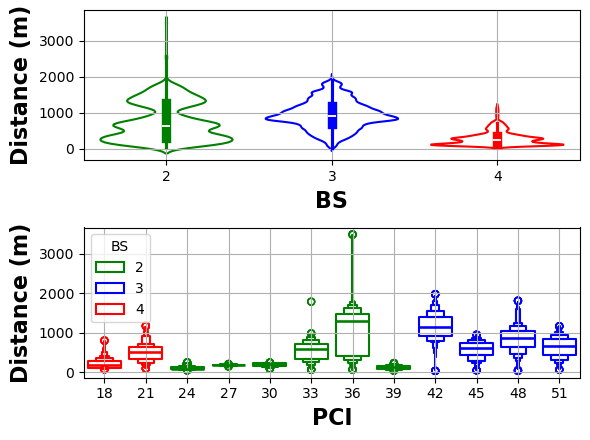

In [6]:
fig, axes = plt.subplots(2, 1, figsize=(6, 4.5), layout='constrained')
sns.violinplot(data=X_interpret, x="BS", y="Distance_3d", hue="BS", palette=['green', 'blue', 'red'], legend=False, fill=False, ax=axes[0])
axes[0].set_ylabel('Distance (m)', fontsize=16, fontweight='bold')
axes[0].set_xlabel('BS', fontsize=16, fontweight='bold')
axes[0].grid(True)
sns.boxenplot(data=X_interpret, x="PCI", y="Distance_3d", hue='BS', palette=['green', 'blue', 'red'], fill=False, ax=axes[1])
axes[1].set_ylabel('Distance (m)', fontsize=16, fontweight='bold')
axes[1].set_xlabel('PCI', fontsize=16, fontweight='bold')
axes[1].grid(True)
plt.tight_layout()
plt.show()

del fig, axes

BS-2 data count is less, and from the deployment map, we are aware that not all PCIs were covered for measurements. This was because the measurement campaign was performed primarily to study BS-3,4. So, moving forward, **ALL BS-2 measurements are discarded**.

In [7]:
df_2 = df[df['BS'].isin([3, 4])]
X_interpret_2 = X_interpret[X_interpret['BS'].isin([3, 4])]

C:\Users\jpalathi\AppData\Local\Temp\ipykernel_22336\2536705265.py:10: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


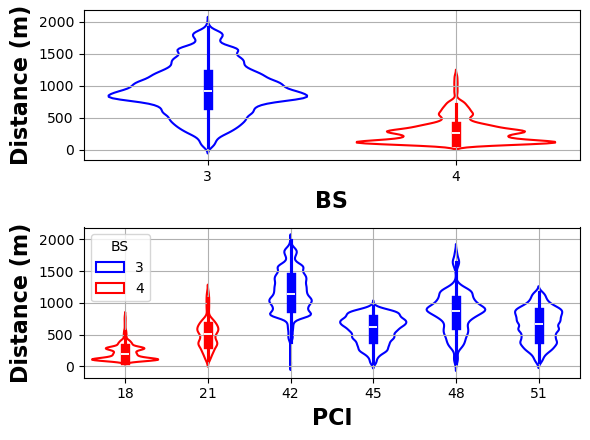

In [8]:
fig, axes = plt.subplots(2, 1, figsize=(6, 4.5),layout='constrained')
sns.violinplot(data=X_interpret_2, x="BS", y="Distance_3d", hue="BS", palette=['blue', 'red'], legend=False, fill=False, ax=axes[0])
axes[0].set_ylabel('Distance (m)', fontsize=16, fontweight='bold')
axes[0].set_xlabel('BS', fontsize=16, fontweight='bold')
axes[0].grid(True)
sns.violinplot(data=X_interpret_2, x="PCI", y="Distance_3d", hue='BS', palette=['blue', 'red'], fill=False, ax=axes[1])
axes[1].set_ylabel('Distance (m)', fontsize=16, fontweight='bold')
axes[1].set_xlabel('PCI', fontsize=16, fontweight='bold')
axes[1].grid(True)
plt.tight_layout()
plt.show()

del fig, axes

C:\Users\jpalathi\AppData\Local\Temp\ipykernel_22336\2969420173.py:10: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


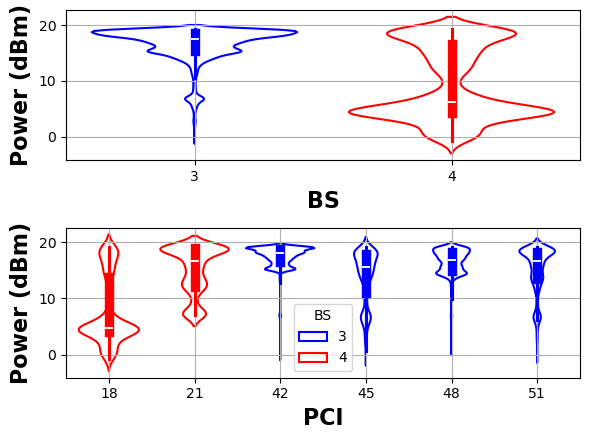

In [9]:
fig, axes = plt.subplots(2, 1, figsize=(6, 4.5),layout='constrained')
sns.violinplot(data=X_interpret_2, x="BS", y="bs_Power", hue="BS", palette=['blue', 'red'], legend=False, fill=False, ax=axes[0])
axes[0].set_ylabel('Power (dBm)', fontsize=16, fontweight='bold')
axes[0].set_xlabel('BS', fontsize=16, fontweight='bold')
axes[0].grid(True)
sns.violinplot(data=X_interpret_2, x="PCI", y="bs_Power", hue='BS', palette=['blue', 'red'], fill=False, ax=axes[1])
axes[1].set_ylabel('Power (dBm)', fontsize=16, fontweight='bold')
axes[1].set_xlabel('PCI', fontsize=16, fontweight='bold')
axes[1].grid(True)
plt.tight_layout()
plt.show()

del fig, axes

C:\Users\jpalathi\AppData\Local\Temp\ipykernel_22336\1855486825.py:10: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


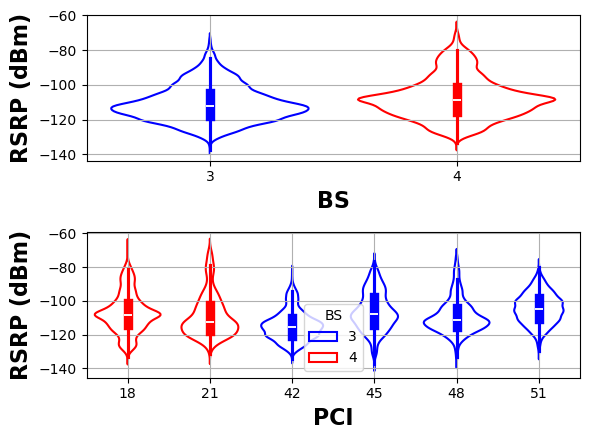

In [10]:
fig, axes = plt.subplots(2, 1, figsize=(6, 4.5),layout='constrained')
sns.violinplot(data=X_interpret_2, x="BS", y="RSRP", hue="BS", palette=['blue', 'red'], legend=False, fill=False, ax=axes[0])
axes[0].set_ylabel('RSRP (dBm)', fontsize=16, fontweight='bold')
axes[0].set_xlabel('BS', fontsize=16, fontweight='bold')
axes[0].grid(True)
sns.violinplot(data=X_interpret_2, x="PCI", y="RSRP", hue='BS', palette=['blue', 'red'], fill=False, ax=axes[1])
axes[1].set_ylabel('RSRP (dBm)', fontsize=16, fontweight='bold')
axes[1].set_xlabel('PCI', fontsize=16, fontweight='bold')
axes[1].grid(True)
plt.tight_layout()
plt.show()

del fig, axes

C:\Users\jpalathi\AppData\Local\Temp\ipykernel_22336\878199328.py:14: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


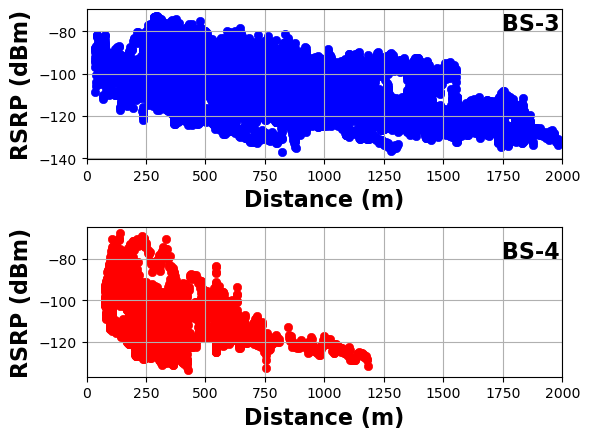

In [11]:
fig, axes = plt.subplots(2, 1, figsize=(6, 4.5),layout='constrained')
sns.scatterplot(data=X_interpret_2[X_interpret_2['BS'] == 3], x='Distance_3d', y='RSRP', edgecolor=None, ax=axes[0], color='blue')
axes[0].set_xlim(0, 2000)
axes[0].set_xlabel('Distance (m)', fontsize=16, fontweight='bold')
axes[0].set_ylabel('RSRP (dBm)', fontsize=16, fontweight='bold')
axes[0].grid(True)
axes[0].text(1990, axes[0].get_ylim()[1]-10, 'BS-3', fontsize=16, fontweight='bold', color='black', ha='right')
sns.scatterplot(data=X_interpret_2[X_interpret_2['BS'] == 4], x='Distance_3d', y='RSRP', edgecolor=None, ax=axes[1], color='red')
axes[1].set_xlim(0, 2000)
axes[1].set_xlabel('Distance (m)', fontsize=16, fontweight='bold')
axes[1].set_ylabel('RSRP (dBm)', fontsize=16, fontweight='bold')
axes[1].grid(True)
axes[1].text(1990, axes[0].get_ylim()[1]-10, 'BS-4', fontsize=16, fontweight='bold', color='black', ha='right')
plt.tight_layout()
plt.show()

del fig, axes

C:\Users\jpalathi\AppData\Local\Temp\ipykernel_22336\2739906595.py:10: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


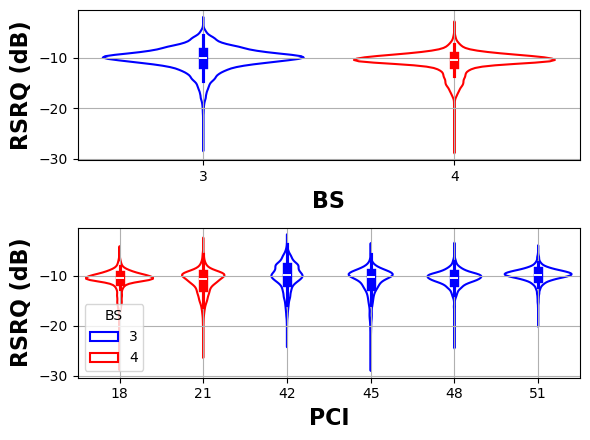

In [12]:
fig, axes = plt.subplots(2, 1, figsize=(6, 4.5),layout='constrained')
sns.violinplot(data=X_interpret_2, x="BS", y="RSRQ", hue="BS", palette=['blue', 'red'], legend=False, fill=False, ax=axes[0])
axes[0].set_ylabel('RSRQ (dB)', fontsize=16, fontweight='bold')
axes[0].set_xlabel('BS', fontsize=16, fontweight='bold')
axes[0].grid(True)
sns.violinplot(data=X_interpret_2, x="PCI", y="RSRQ", hue='BS', palette=['blue', 'red'], fill=False, ax=axes[1])
axes[1].set_ylabel('RSRQ (dB)', fontsize=16, fontweight='bold')
axes[1].set_xlabel('PCI', fontsize=16, fontweight='bold')
axes[1].grid(True)
plt.tight_layout()
plt.show()

del fig, axes

C:\Users\jpalathi\AppData\Local\Temp\ipykernel_22336\947183731.py:10: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


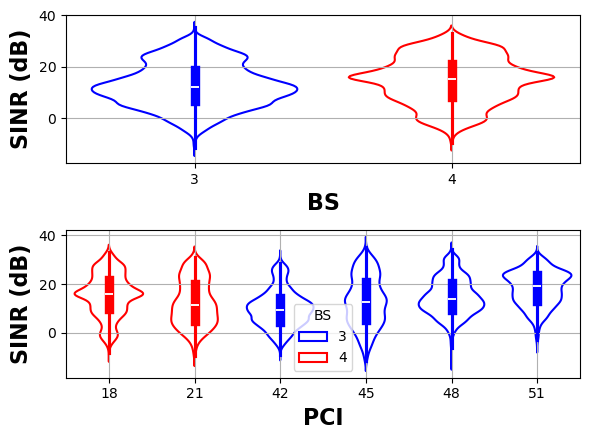

In [13]:
fig, axes = plt.subplots(2, 1, figsize=(6, 4.5),layout='constrained')
sns.violinplot(data=X_interpret_2, x="BS", y="SINR", hue="BS", palette=['blue', 'red'], legend=False, fill=False, ax=axes[0])
axes[0].set_ylabel('SINR (dB)', fontsize=16, fontweight='bold')
axes[0].set_xlabel('BS', fontsize=16, fontweight='bold')
axes[0].grid(True)
sns.violinplot(data=X_interpret_2, x="PCI", y="SINR", hue='BS', palette=['blue', 'red'], fill=False, ax=axes[1])
axes[1].set_ylabel('SINR (dB)', fontsize=16, fontweight='bold')
axes[1].set_xlabel('PCI', fontsize=16, fontweight='bold')
axes[1].grid(True)
plt.tight_layout()
plt.show()

del fig, axes